In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import waterfall_chart

## Wczytanie danych

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

## Przygotwanie zmiennych

Najpierw konwertujemy odpowiedź `S1` na zmienną binarną, gdzie 1 odpowiada informacji `Yes, I am Married`

In [3]:
df['y'] = 1 - df['S1'].cat.codes

### Wybrane zmienne

Do modelu wybrałem następujące zmienne  
1) kategoryczne:  
  a) `Q23` - Between you and [Partner name], who earned more income in 2016,  
  b) `Q28` - Did your parents know [Partner name]’s parents before you met [Partner name]?,  
2) uporządkowane:  
  a) `ppp20072` - Q27: How often do you attend religious services?,  
  b) `w6_how_many` - How many Different people besides [Partner name] have you met for dating, or rom   

Wszystkie zmienne są zakodowane przez kategorię, które odkoduję.

In [4]:
df = df.dropna(subset=['Q23', 'Q28', 'ppp20072', 'w6_how_many'])

In [5]:
X = df[['Q23', 'Q28', 'ppp20072', 'w6_how_many']].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

In [6]:
X.shape

(225, 4)

Zostało nam 225 obserwacji co oznacza, że nie ma sensu uczyć modelu o dużej pojemności. Z tego powodu wybrałem las losowy o 25 drzewach i maksymalnej głębokości 3.

Stworzymy dodatkowo słowniki do zmiennych kategorycznych by łatwiej odwikłać potem kategorię.

In [7]:
d_ppp20072 = dict(enumerate(df['ppp20072'].cat.categories))
d_w6_how_many = dict(enumerate([cat.split(".")[0] for cat in df['w6_how_many'].cat.categories]))

In [8]:
d = {
    'ppp20072': d_ppp20072,
    'w6_how_many': d_w6_how_many
}

## Budowa modelu

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
rf = RandomForestClassifier(n_estimators=25, max_depth=4)

In [11]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Porównanie wpływu zmiennych

In [143]:
def mean_per_set_attrs(X, model, **kwargs):
    X = X.copy()
    means = []
    means.append(model.predict_proba(X)[:,1].mean())
    for kwarg in kwargs:
        X.loc[:, kwarg] = kwargs[kwarg]
        means.append(model.predict_proba(X)[:,1].mean())
    d_ = pd.DataFrame(data={"var":['intercept'] + list(kwargs.keys()), "proba":means}, index = range(len(means)))
    d_['proba'] = d_['proba'].diff().fillna(d_['proba'])
    waterfall_chart.plot(d_['var'], d_['proba'], rotation_value=0, green_color="#77DD77", formatting='{:,.3f}')

### Pierwszy wykres

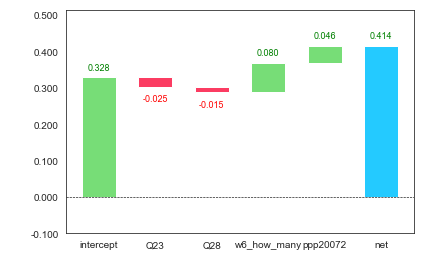

In [144]:
mean_per_set_attrs(X, rf, Q23=3, Q28=2, w6_how_many=3, ppp20072 = 5)

### Drugi wykres

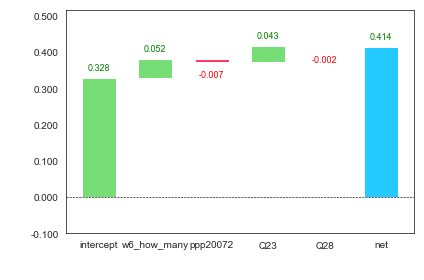

In [145]:
mean_per_set_attrs(X, rf,  w6_how_many=3, ppp20072 = 5, Q23=3, Q28=2)

Jak widać przy różnym ułożeniu kolejności zmiennych zmienia się ich efekt w tej metodzie obrazowania. `Q23` i `Q28` to zmienne o maksymalnie trzech wartościach. Dlatego wrzucenie ich na początku może znacząco zmienić wpływ kolejnych zmiennych, ponieważ mogą mocno dzielić zbiór(tak jak na ćwiczeniach poruszana zmienne płeć przy zbiorze o zwolnieniach). Ciekawie również zmienia się wpływ zmiennej `ppp20072`(wartość=`never`) czyli częstość brania udziału w religijnych obrzędach. Gdy wybieramy tylko z podzbioru ludzi z jednym partnerem(zmienna `w6_how_many` ma ona wpływ negatywny, natomiast biorąc pod uwagę dodatkowy wpływ zarabiania więcej niż partner(`Q23`) i wcześniejszego nie poznania rodziców partnera(`Q28`) zyskuję mocny wpływ dodani.